<a href="https://colab.research.google.com/github/hyunwook-lee/-/blob/master/1day_lstm_dqn_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from google.colab import drive 

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

##전처리 데이터 로드


In [ ]:

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab_data/df_dropna_3456.csv') 

print(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


         Unnamed: 0 CORP_ID  ...         INS_DATETIME          INS-BKG
0                 1   KX007  ...  2021-03-03 13:14:25  0 days 09:19:04
1                 2   KX007  ...  2021-03-03 13:14:25  0 days 09:19:12
2                 3   KX007  ...  2021-03-03 13:14:25  0 days 09:18:17
3                 4   KX007  ...  2021-03-03 13:14:25  0 days 09:18:34
4                 5   KX007  ...  2021-03-03 13:14:25  0 days 09:18:34
...             ...     ...  ...                  ...              ...
1585519     1786343   KX007  ...  2021-07-02 10:14:25  1 days 21:54:24
1585520     1786347   KX007  ...  2021-07-02 12:22:03  2 days 23:53:51
1585521     1786348   KX007  ...  2021-07-03 22:01:52  3 days 21:58:56
1585522     1786349   KX007  ...  2021-07-04 05:50:47  3 days 15:19:29
1585523     1786354   KX007  ...  2021-07-03 00:14:24  3 days 01:39:21

[1585524 rows x 41 columns]


In [ ]:

df_dropna = df
df_dropna["INS_DATETIME"] = pd.to_datetime(df_dropna["INS_DATETIME"])
df_dropna["BKG_DATETIME"] = pd.to_datetime(df_dropna["BKG_DATETIME"])

df_dropna["INS-BKG"] = df_dropna["INS_DATETIME"] - df_dropna["BKG_DATETIME"]
df_dropna["INS-BKG"].dtype

df_dropna['secs']=df_dropna['INS-BKG'].dt.total_seconds()



In [ ]:
df_dropna["SHPR_CD"] = df_dropna["SHPR_CD"].astype(str)
df_dropna["SHPR_CD"].value_counts()
data_df = pd.DataFrame(data = {'쇼핑몰 수': [2], '아이템 합' : [3], 'Count': [4]})

def makeDataToTimeseries(df):
    timeseries_df = pd.DataFrame()
    timeseries_df['Date'] = df.BKG_DATE.unique()
    timeseries_df['Date'] = timeseries_df['Date']
    print(timeseries_df)
    timeseries_df['ItmeCount'] = timeseries_df.Date.map(lambda x: len(df.query(f' BKG_DATE == "{x}"').ITEM_CD.unique()))
    print(timeseries_df)
    timeseries_df['MallCount'] = timeseries_df.Date.map(lambda x: len(df.query(f' BKG_DATE == "{x}"').SHPR_CD.unique()))
    print(timeseries_df)
    timeseries_df['TotalCount'] = timeseries_df.Date.map(lambda x: df.query(f' BKG_DATE == "{x}"').shape[0])
    print(timeseries_df)
    timeseries_df['Total_Sconds'] = timeseries_df.Date.map(lambda x: sum(df.query(f' BKG_DATE == "{x}"').secs))
    print(timeseries_df)

    return timeseries_df

timedf = makeDataToTimeseries(df_dropna)
print(timedf)


                    Date
0    2021-03-03 00:00:00
1    2021-03-01 00:00:00
2    2021-03-02 00:00:00
3    2021-03-04 00:00:00
4    2021-03-05 00:00:00
..                   ...
117  2021-06-24 00:00:00
118  2021-06-26 00:00:00
119  2021-06-27 00:00:00
120  2021-06-25 00:00:00
121  2021-06-30 00:00:00

[122 rows x 1 columns]
                    Date  ItmeCount
0    2021-03-03 00:00:00       1746
1    2021-03-01 00:00:00       1620
2    2021-03-02 00:00:00       1697
3    2021-03-04 00:00:00       1570
4    2021-03-05 00:00:00       1318
..                   ...        ...
117  2021-06-24 00:00:00       3303
118  2021-06-26 00:00:00       3005
119  2021-06-27 00:00:00       3659
120  2021-06-25 00:00:00       3214
121  2021-06-30 00:00:00       3553

[122 rows x 2 columns]
                    Date  ItmeCount  MallCount
0    2021-03-03 00:00:00       1746          8
1    2021-03-01 00:00:00       1620          8
2    2021-03-02 00:00:00       1697          8
3    2021-03-04 00:00:00       1

In [ ]:
timedf["Date"] = pd.to_datetime(timedf.Date)
timedf.sort_values(by='Date', inplace=True)
timedf

total_count_list = list(timedf["ItmeCount"])
for x in range(len(total_count_list)-1):
    if x != len(total_count_list)-1:
        total_count_list[x] = total_count_list[x+1] - total_count_list[x]
    else:
        total_count_list[x+1] = 0
for x in range(len(total_count_list)):
    if x == 0:
        total_count_list.pop()
        total_count_list.insert(0,0)
df = pd.DataFrame({"item_count_dif" : total_count_list})

timedf.insert(2,"item_count_dif",df)
timedf

,Date,ItmeCount,item_count_dif,MallCount,TotalCount,Total_Sconds
1,2021-03-01,1620,77,8,7893,262044355.0
2,2021-03-02,1697,49,8,10996,368102356.0
0,2021-03-03,1746,0,8,12825,426622824.0
3,2021-03-04,1570,-176,8,9510,315867482.0
4,2021-03-05,1318,-252,8,12225,406226818.0
...,...,...,...,...,...,...
118,2021-06-26,3005,654,18,14204,472242739.0
119,2021-06-27,3659,-51,18,17810,591841810.0
108,2021-06-28,3608,34,19,24813,139147705.0
103,2021-06-29,3720,-292,20,18054,20554054.0


In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scale_cols = ['TotalCount']
df_scaled = scaler.fit_transform(timedf[scale_cols])


scaled = scaler.fit_transform(timedf[['TotalCount']])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,TotalCount
0,0.108910
1,0.212575
2,0.273678
3,0.162931
4,0.253633
...,...
117,0.319747
118,0.440216
119,0.674172
120,0.448368


In [ ]:
# output 1 하나가 결과로 나옴

TEST_SIZE = 60
train = df_scaled[:-TEST_SIZE].astype(float)
test = df_scaled[-TEST_SIZE:].astype(float)

def make_train_dataset(data, label, window_size=7):
    feature_list = []
    label_list = []
    for i in range(0,len(data) - window_size, 7):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))   
    return np.array(feature_list), np.array(label_list)
def make_test_dataset(data, label, window_size=7):
    feature_list = []
    label_list = []
    for i in range(0,len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))   
    return np.array(feature_list), np.array(label_list)

feature_cols = ['TotalCount']
label_cols = ['TotalCount']

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature, test_label = test[feature_cols], test[label_cols]

# train dataset
train_feature, train_label = make_train_dataset(train_feature, train_label)

# train set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_test_dataset(test_feature, test_label)
test_feature.shape, test_label.shape

((53, 7, 1), (53, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from tensorflow.keras import layers



print(train_feature.shape[1], train_feature.shape[2])
model = Sequential()
model.add(LSTM(128, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='tanh', 
               return_sequences=False)
          )
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))
model.summary()

7 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import os


model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=40)
filename = os.path.join("/a/b/c", 'tmp_checkpoint.h5')
history = model.fit(x_train, y_train, epochs=10000,batch_size=1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
6/6 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 7502/10000
6/6 [==============================] - 0s 10ms/step - loss: 0.0000e+00
Epoch 7503/10000
6/6 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 7504/10000
6/6 [==============================] - 0s 12ms/step - loss: 0.0000e+00
Epoch 7505/10000
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00
Epoch 7506/10000
6/6 [==============================] - 0s 8ms/step - loss: 0.0000e+00
Epoch 7507/10000
6/6 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 7508/10000
6/6 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 7509/10000
6/6 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 7510/10000
6/6 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 7511/10000
6/6 [==============================] - 0s 7ms/step - loss: 0.0000e+00
Epoch 7512/10000
6/6 [

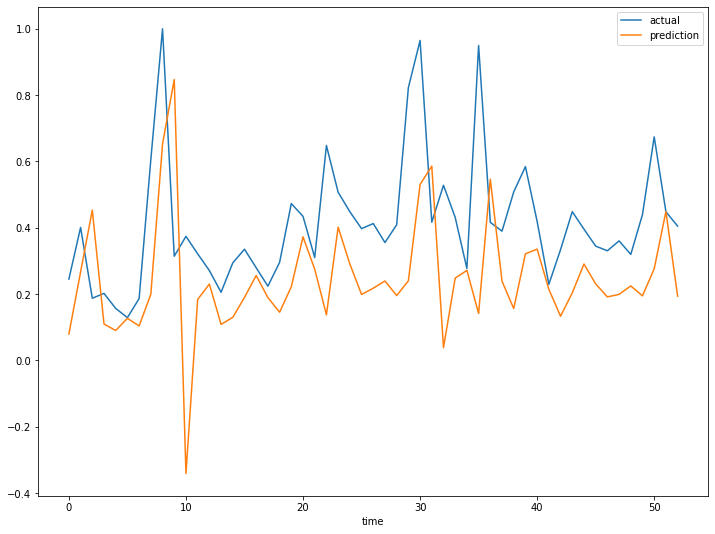

[10431.1875]


In [ ]:
pred = model.predict(test_feature)

plt.figure(figsize=(12, 9))
# b = scaler.inverse_transform(np.array(pred).reshape(-1,1))
# print(b)
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.xlabel("time")
plt.legend()
plt.show()
d = scaler.inverse_transform(np.array(pred).reshape(-1,1))
prediction_7days = d[-1:]
prediction_7days = list(prediction_7days.reshape(-1))
print(prediction_7days)

# DQN

In [ ]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
import pandas as pd
from matplotlib import animation, rc
plt.rcParams.update({'pdf.fonttype': 'truetype'})

# from qbstyles import mpl_style
# mpl_style(dark=False)

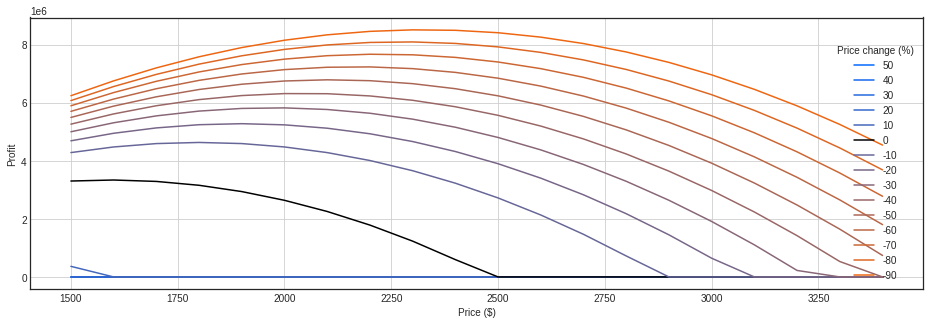

In [ ]:
## Environment simulator
def plus(x):
    return 0 if x < 0 else x

def minus(x):
    return 0 if x > 0 else -x

def shock(x):
    return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
    return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))
demand_result = []
def q_t_r(p_t, p_t_1, q_0, k, a, b):
    
    demand_result.append(plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1))))
    return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

def profit_t_r(p_t, p_t_1, q_0, k, a, b, unit_cost):
    return q_t_r(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

def profit_total_r(p, unit_cost, q_0, k, a, b):
    return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t_r(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))


## Environment parameters
T = 7
price_max = 3500
price_step = 100
q_0 = 10431
k = 4.2
unit_cost = 700
a_q = 300
b_q = 100

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
    return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)
def profit_response_result(p):
    return profit_total_r(p, unit_cost, q_0, k, a_q, b_q)
def profit_response(p):
    return profit_total(p, unit_cost, q_0, k, a_q, b_q)

## Visualize price-demand functions
price_grid = np.arange(1500, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
    for j in range(len(price_change_grid)):
        profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j])

plt.figure(figsize=(16, 5))
for i in range(len(price_change_grid)):
    if math.isclose(price_change_grid[i], 1.0):
        color = 'black'
    else:
        p_norm = (price_change_grid[i]-0.5)/1.5
        color = (p_norm, 0.4, 1 - p_norm)
    plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((1-price_change_grid)*100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)
plt.grid(True)


In [ ]:

# Find optimal constant price
Profit =[]
Price_Decision_model = []
profits = np.array([ profit_response(np.repeat(p, T)) for p in price_grid ])
p_idx = np.argmax(profits)
price_opt_const = price_grid[p_idx]

print(f'Optimal price is {price_opt_const}, achieved profit is {profits[p_idx]}')
Profit.append(profits[p_idx])
Price_Decision_model.append('optimal price')

Optimal price is 1600, achieved profit is 26719200.0


[1600 3400 2100 1800 1700 1600 3400]
Achieved profit is 31395604.29238271


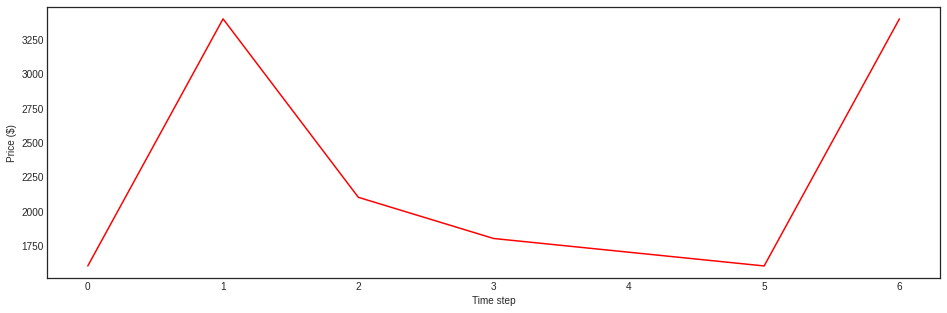

In [ ]:
# Find optimal sequence of prices using greedy search

def find_optimal_price_t(p_baseline, price_grid, t):
    p_grid = np.tile(p_baseline, (len(price_grid), 1))
    p_grid[:, t] = price_grid
    profit_grid = np.array([ profit_response(p) for p in p_grid ])
    return price_grid[ np.argmax(profit_grid) ]

p_opt = np.repeat(price_opt_const, T)
for t in range(T):
    price_t = find_optimal_price_t(p_opt, price_grid, t)
    p_opt[t] = price_t

print(p_opt)
print(f'Achieved profit is {profit_response(p_opt)}')

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.xticks(np.arange(T))
plt.plot(np.arange(T), p_opt, c='red')

Profit.append(profit_response(p_opt))
Price_Decision_model.append('greedy')

In [ ]:

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
    plt.figure(figsize=(16, 5))
    plt.xlabel("Episode")
    plt.ylabel("Return ($)")
    returns_df = pd.Series(returns)
    ma = returns_df.rolling(window=smoothing_window).mean()
    mstd = returns_df.rolling(window=smoothing_window).std()
    plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
    plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
    plt.figure(fig_number);
    plt.xlabel("Time step");
    plt.ylabel("Price ($)");
    plt.xticks(range(T))
    plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
    return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
            
    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

In [ ]:
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(PolicyNetworkDQN, self).__init__()
        layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        q_values = self.model(x)
        return q_values  

class AnnealedEpsGreedyPolicy(object):
    def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.steps_done = 0

    def select_action(self, q_values):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if sample > eps_threshold:
            return np.argmax(q_values)
        else:
            return random.randrange(len(q_values))

GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512

def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def env_intial_state():
    return np.repeat(0, 2*T)

def env_step(t, state, action):
    next_state = np.repeat(0, len(state))
    next_state[0] = price_grid[action]
    next_state[1:T] = state[0:T-1]
    next_state[T+t] = 1
    reward = profit_t_response(next_state[0], next_state[1])
    return next_state, reward

def to_tensor(x):
    return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
    return torch.tensor([[x]], device=device, dtype=torch.long)

policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 5000
return_trace = []
p_trace = [] # price schedules used in each episode
for i_episode in range(num_episodes):
    state = env_intial_state()
    reward_trace = []
    p = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
            q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state), 
                    to_tensor_long(action), 
                    to_tensor(next_state) if t != T - 1 else None, 
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

plot_return_trace(return_trace)

fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 5, 1, fig.number)

list_profit = []
demand_result = []
for s in p_trace:
    list_profit.append(profit_response(s))
print(max(list_profit))
print(p_trace[list_profit.index(max(list_profit))])
print(profit_response_result(p_trace[list_profit.index(max(list_profit))]))
print(demand_result)
for profit in sorted(profit_response(s) for s in p_trace)[-10:]:
    print(f'Best profit results: {profit}')

Profit.append(profit)
Price_Decision_model.append('DQN')

In [ ]:
df_Profit = pd.DataFrame({'Price_Decision_Model':Price_Decision_model,'Profit':Profit })
df_Profit

In [ ]:
colors = sns.color_palette('Greys',len(df_Profit))

fig50=plt.figure(figsize=(5,5))
fig50.set_facecolor('white')
ax = fig50.add_subplot()

bars = ax.bar(df_Profit['Price_Decision_Model'],df_Profit['Profit'],color=colors)

ax.legend(handles = bars,labels =list(df_Profit['Price_Decision_Model']))
ax.set(ylabel='Profit',title="Profit model performance")


plt.show()
#plt.savefig('/content/drive/MyDrive/Colab_data/profitPerformance.jpg')

In [ ]:
demand_cv=[0.45190135801852854,0.33142881859194756]
Price_decision_model=['prediction demand','dynamic pricing demand']
df_cv = pd.DataFrame({'cv':demand_cv,'comparison':Price_decision_model})

In [ ]:
colors = sns.color_palette('Greys',len(df_cv))

fig51=plt.figure(figsize=(6,5))
fig51.set_facecolor('white')
ax40 = fig51.add_subplot()

bars = ax40.bar(df_cv['comparison'],df_cv['cv'],color=colors)

ax40.legend(handles = bars,labels =list(df_cv['comparison']))
ax40.set(ylabel='cv',title="cv model performance")


plt.show()
plt.savefig('/content/drive/MyDrive/Colab_data/cvPerformance.png')